In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from aligner_v3 import Aligner

In [8]:
# stack = 'CHATM2'
# stack = 'CHATM3'

In [9]:
detector_id = 19

In [10]:
warp_setting = 7

In [ ]:
# for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:

# for stack in ['CHATM2', 'CHATM3']:
for stack in ['MD589']:

#     for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
#     for structure_m in [('3N_L', '4N_L'), ('3N_R', '4N_R')]:
    for structure_m in [('SC', 'IC')]:
#     for structure_m in ['Amb_L', 'Amb_R']:

        is_complex = not isinstance(structure_m, str)

        if is_complex:

            structures_m = structure_m

            stack_m_spec = dict(name='atlasV6',
                               vol_type='score',
                                resolution='10.0um'
                               )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                                resolution='10.0um'
                               )

        else:

            structures_m = [structure_m]

            stack_m_spec = dict(name='atlasV6',
                               vol_type='score',
                               structure=structure_m,
                                resolution='10.0um'
                               )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                               structure=convert_to_original_name(structure_m),
                                resolution='10.0um'
                               )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=warp_setting)        

        local_aligner_parameters = generate_aligner_parameters_v2(alignment_spec=local_alignment_spec,
        structures_m=structures_m,
        fixed_structures_are_sided=True,
        fixed_surroundings_have_positive_value=False,
                                                                  fixed_use_surround=False,
        )

        aligner = Aligner(local_aligner_parameters['volume_fixed'], 
                          local_aligner_parameters['volume_moving'], 
                          labelIndexMap_m2f=local_aligner_parameters['label_mapping_m2f'])

        aligner.compute_gradient(smooth_first=True)
        aligner.set_label_weights(label_weights=local_aligner_parameters['label_weights_m'])
        
        T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = bp.unpack_ndarray_file('/home/yuncong/' + stack_f_spec['name'] + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp')

        aligner.set_initial_transform(transform=T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol)

        if is_complex:
            aligner.set_centroid(centroid_m='volume_centroid', 
                             centroid_f='centroid_m')
        else:
            aligner.set_centroid(
                centroid_m='structure_centroid', 
                                 centroid_f='centroid_m')
#                                 indices_m=[local_aligner_parameters['structure_to_label_moving'][structure_m]])

        if 'SC' in structures_m or 'IC' in structures_m:
            grid_search_iteration_number = 0
        else:
            grid_search_iteration_number = 3
            
        grid_search_T, _ = aligner.do_grid_search(grid_search_iteration_number=grid_search_iteration_number, 
                                                  grid_search_sample_number=10, 
                               std_tx=100, std_ty=100, std_tz=30, 
                               grid_search_eta=3.0, 
                               stop_radius_voxel=10, indices_m=None, parallel=True, 
                               init_T=None)

        init_T = grid_search_T
        aligner.set_initial_transform(init_T)  

        if is_complex:
            aligner.set_centroid(centroid_m='volume_centroid', 
                             centroid_f='centroid_m')
        else:
            aligner.set_centroid(centroid_m='structure_centroid', 
                                 centroid_f='centroid_m')
#                                 indices_m=[local_aligner_parameters['structure_to_label_moving'][structure_m]])
        
        t = time.time()
        _, _ = aligner.optimize(tf_type=local_aligner_parameters['transform_type'], 
                                grad_computation_sample_number=1000,
#                                 grad_computation_sample_number=None,
#                                     max_iter_num=100,
                                     max_iter_num=10000,
                                     history_len=100, 
                                     terminate_thresh_trans=.01,
                                    terminate_thresh_rot=.01,
                                     full_lr=np.array([1,1,1,.01,.01,.01]),
        #                         full_lr=np.array([10,10,10,.1,.1,.1]),
                                    )
        sys.stderr.write("Optimize: %.2f seconds.\n" % (time.time() - t))

        plot_alignment_results(traj=aligner.Ts, scores=aligner.scores, select_best='max_value')

        #     tf_atlas_to_subj = compose_alignment_parameters([T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, 
        #                                                              convert_transform_forms(aligner=aligner, out_form=(3,4))])

        tf_atlas_to_subj = compose_alignment_parameters([init_T, convert_transform_forms(aligner=aligner, out_form=(3,4))])


        for structure_m in structures_m:

            stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                               structure=convert_to_original_name(structure_m),
                                resolution='10.0um'
                               )

            local_alignment_spec = dict(stack_m=stack_m_spec, 
                                  stack_f=stack_f_spec,
                                  warp_setting=warp_setting)

            DataManager.save_alignment_results_v3(transform_parameters=convert_transform_forms(transform=tf_atlas_to_subj, out_form='dict'),
                           score_traj=aligner.scores,
                           parameter_traj=aligner.Ts,
                          alignment_spec=local_alignment_spec)

            tf_atlas_to_subj = DataManager.load_alignment_results_v3(local_alignment_spec, what='parameters', out_form=(4,4))

            atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
            DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=structure_m)

            aligned_structure_wrt_wholebrain_inputResol = \
            transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                                transform=tf_atlas_to_subj,
                                return_origin_instead_of_bbox=True)

            DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
                                                   alignment_spec=local_alignment_spec)
            
            
            ###########################################################################################
            
            stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                               structure=convert_to_original_name(structure_m),
                                resolution='10.0um'
                               )

            simpleGlobal_alignment_spec = dict(stack_m=stack_m_spec, 
                                  stack_f=stack_f_spec,
                                  warp_setting=0)

            atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
            DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=structure_m)

            aligned_structure_wrt_wholebrain_inputResol = \
            transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                                transform=init_T,
                                return_origin_instead_of_bbox=True)

            DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
                                                   alignment_spec=simpleGlobal_alignment_spec)

upstream_warp_id                                                               None
transform_type                                                                rigid
grad_computation_sample_number                                               100000
grid_search_sample_number                                                      1000
std_tx_um                                                                        50
std_ty_um                                                                        50
std_tz_um                                                                        50
std_theta_xy_degree                                                              10
surround_weight                                                             inverse
regularization_weight                                                           NaN
terminate_thresh_trans                                                         0.01
terminate_thresh_rot                                                        

Prior structure/index map not found. Generating a new one.
Loaded moving volumes: ['IC', 'IC_surround_200um', 'SC', 'SC_surround_200um'].
Prior structure/index map not found. Generating a new one.


loaded_cropbox_resolution 10.0um
loaded_cropbox_resolution 10.0um


Loaded fixed volumes: ['IC', 'SC'].
Computing structure sizes: 0.11 s


voxel size for moving = 10.00 um
voxel size for fixed = 10.00 um
label_mapping_m2f {1: 1, 2: 2, 3: 2, 4: 1}
{1: 1.0, 2: -0.7520834331528596, 3: 1.0, 4: -1.1102728513614557}


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
indices_f: set([1, 2])
Set initial transform to [ 9.99181511e-01 -4.04613008e-02  0.00000000e+00  1.17709838e+03
  4.04613008e-02  9.99181511e-01  0.00000000e+00  5.52968802e+02
  0.00000000e+00  0.00000000e+00  1.00000000e+00  4.52000000e+02].
centroid_m: [1085.24437745  325.06555202  454.        ], centroid_f: [1085.24437745  325.06555202  454.        ]
Set initial transform to [ 9.99181511e-01 -4.04613008e-02  0.00000000e+00  1.17709838e+03
  4.04613008e-02  9.99181511e-01  0.00000000e+00  5.52968802e+02
  0.00000000e+00  0.00000000e+00  1.00000000e+00  4.52000000e+02].
centroid_m: [1085.24437745  325.06555202  454.        ], centroid_f: [1085.24437745  325.06555202  454.        ]

iteration 0
Norm of gradient (translation) = 1.732051
Norm of gradient (rotation) = 1.732051
around x=0.57; around y=0.58; around z=-0.57
step: 0.31 seconds
current score: -0.000137
new_T: [ 0.9999      0

Norm of gradient (translation) = 0.399158
Norm of gradient (rotation) = 0.400260
around x=-2.57; around y=4.39; around z=-3.34
step: 0.30 seconds
current score: -0.000126
new_T: [ 0.99537554  0.05477697  0.07891147  6.86272541 -0.05809423  0.99749442
  0.04037255 -0.34471435 -0.07650226 -0.04477015  0.99606377 -9.24177908]
det: 1.00

iteration 21
2: 996 valid, 4 out-of-bound voxels after transform.
3: 996 valid, 4 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.512476
Norm of gradient (rotation) = 0.455649
around x=-2.81; around y=4.49; around z=-3.30
step: 0.30 seconds
current score: -0.000127
new_T: [ 0.99528833  0.05358959  0.08080403  7.02245201 -0.05730741  0.99736815
  0.04441423  0.05582494 -0.07821123 -0.04883564  0.99573997 -9.46938719]
det: 1.00

iteration 22
2: 997 valid, 3 out-of-bound voxels after transform.
3: 994 valid, 6 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.301353
Norm of gradient (rotation) = 0.293278
around x=

2: 989 valid, 11 out-of-bound voxels after transform.
3: 979 valid, 21 out-of-bound voxels after transform.
4: 999 valid, 1 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.109187
Norm of gradient (rotation) = 0.095231
around x=-3.32; around y=5.84; around z=-4.74
step: 0.30 seconds
current score: -0.000176
new_T: [  0.99140781   0.07665467   0.10599343   8.97422473  -0.08223187
   0.99539392   0.04928342  -1.61310252  -0.10172742  -0.057576
   0.99314477 -12.42114454]
det: 1.00

iteration 39
2: 993 valid, 7 out-of-bound voxels after transform.
3: 990 valid, 10 out-of-bound voxels after transform.
4: 998 valid, 2 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.358766
Norm of gradient (rotation) = 0.231776
around x=-3.43; around y=5.87; around z=-4.69
step: 0.30 seconds
current score: -0.000160
new_T: [  0.99141122   0.07558597   0.10672652   9.10609027  -0.08140959
   0.99535958   0.0513009   -1.29851663  -0.10235363  -0.05954885
   0.9929

2: 982 valid, 18 out-of-bound voxels after transform.
3: 971 valid, 29 out-of-bound voxels after transform.
4: 998 valid, 2 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.150129
Norm of gradient (rotation) = 0.228784
around x=-3.36; around y=6.77; around z=-5.72
step: 0.30 seconds
current score: -0.000202
new_T: [  0.98809827   0.09254955   0.12286738  10.45667789  -0.09890049
   0.99400441   0.04662538  -2.60934659  -0.11781556  -0.0582221
   0.99132723 -14.25627986]
det: 1.00

iteration 56
1: 999 valid, 1 out-of-bound voxels after transform.
2: 979 valid, 21 out-of-bound voxels after transform.
3: 970 valid, 30 out-of-bound voxels after transform.
4: 999 valid, 1 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.106647
Norm of gradient (rotation) = 0.088611
around x=-3.40; around y=6.79; around z=-5.73
step: 0.30 seconds
current score: -0.000186
new_T: [  0.98802471   0.09260083   0.12341904  10.51137201  -0.09906482
   0.99395633   0.04

2: 963 valid, 37 out-of-bound voxels after transform.
3: 969 valid, 31 out-of-bound voxels after transform.
4: 996 valid, 4 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.170837
Norm of gradient (rotation) = 0.129026
around x=-3.39; around y=7.48; around z=-6.39
step: 0.30 seconds
current score: -0.000227
new_T: [  0.98532076   0.10345276   0.13579588  11.51423708  -0.11035054
   0.99290627   0.04427076  -3.31055527  -0.13025264  -0.05860605
   0.98974723 -15.7615016 ]
det: 1.00

iteration 73
2: 970 valid, 30 out-of-bound voxels after transform.
3: 973 valid, 27 out-of-bound voxels after transform.
4: 998 valid, 2 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.219371
Norm of gradient (rotation) = 0.211465
around x=-3.32; around y=7.53; around z=-6.48
step: 0.30 seconds
current score: -0.000223
new_T: [  0.9850599    0.10503584   0.1364715   11.57441644  -0.11179978
   0.99280601   0.04286071  -3.50448726  -0.13098782  -0.05747785
   0.9

2: 962 valid, 38 out-of-bound voxels after transform.
3: 967 valid, 33 out-of-bound voxels after transform.
4: 997 valid, 3 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.089065
Norm of gradient (rotation) = 0.077537
around x=-3.39; around y=8.15; around z=-7.08
step: 0.30 seconds
current score: -0.000233
new_T: [  0.98234292   0.11475007   0.14776609  12.29000262  -0.12204079
   0.99166851   0.04122646  -4.42920152  -0.14180424  -0.05853201
   0.98816272 -17.36954585]
det: 1.00

iteration 89
1: 999 valid, 1 out-of-bound voxels after transform.
2: 965 valid, 35 out-of-bound voxels after transform.
3: 951 valid, 49 out-of-bound voxels after transform.
4: 998 valid, 2 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.233914
Norm of gradient (rotation) = 0.265842
around x=-3.28; around y=8.18; around z=-7.17
step: 0.30 seconds
current score: -0.000226
new_T: [  0.98207147   0.11657707   0.14813983  12.34577321  -0.12360134
   0.99156141   0.0

2: 957 valid, 43 out-of-bound voxels after transform.
3: 944 valid, 56 out-of-bound voxels after transform.
4: 990 valid, 10 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.112127
Norm of gradient (rotation) = 0.106375
around x=-3.23; around y=8.61; around z=-7.56
step: 0.30 seconds
current score: -0.000246
new_T: [  0.9801362    0.12295459   0.15561233  12.91641895  -0.13003316
   0.99085158   0.03611829  -5.15579176  -0.14974781  -0.05563561
   0.98715767 -18.38184847]
det: 1.00

iteration 104
1: 997 valid, 3 out-of-bound voxels after transform.
2: 954 valid, 46 out-of-bound voxels after transform.
3: 948 valid, 52 out-of-bound voxels after transform.
4: 996 valid, 4 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.070810
Norm of gradient (rotation) = 0.067586
around x=-3.20; around y=8.63; around z=-7.58
step: 0.30 seconds
current score: -0.000238
new_T: [  0.98003447   0.12338178   0.15591464  12.95167123  -0.13040934
   0.99081951   0

2: 943 valid, 57 out-of-bound voxels after transform.
3: 948 valid, 52 out-of-bound voxels after transform.
4: 993 valid, 7 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.088620
Norm of gradient (rotation) = 0.124986
around x=-3.02; around y=9.00; around z=-7.97
step: 0.33 seconds
current score: -0.000268
new_T: [  0.97814396   0.13031714   0.16202419  13.35873464  -0.13696305
   0.9901065    0.03049998  -5.92918184  -0.15644653  -0.0520247
   0.98631532 -19.32694726]
det: 1.00

iteration 119
1: 996 valid, 4 out-of-bound voxels after transform.
2: 957 valid, 43 out-of-bound voxels after transform.
3: 941 valid, 59 out-of-bound voxels after transform.
4: 998 valid, 2 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.144993
Norm of gradient (rotation) = 0.167647
around x=-2.95; around y=9.03; around z=-8.02
step: 0.30 seconds
current score: -0.000257
new_T: [  0.97794399   0.13134867   0.1623979   13.38388368  -0.13780352
   0.9900322    0.0

2: 925 valid, 75 out-of-bound voxels after transform.
3: 945 valid, 55 out-of-bound voxels after transform.
4: 987 valid, 13 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.032820
Norm of gradient (rotation) = 0.045589
around x=-2.40; around y=9.32; around z=-8.50
step: 0.31 seconds
current score: -0.000325
new_T: [ 9.75958959e-01  1.40899143e-01  1.66287530e-01  1.37624885e+01
 -1.45773781e-01  9.89164565e-01  1.74203583e-02 -7.06583063e+00
 -1.62031218e-01 -4.12419167e-02  9.85923419e-01 -1.99693545e+01]
det: 1.00

iteration 134
1: 996 valid, 4 out-of-bound voxels after transform.
2: 924 valid, 76 out-of-bound voxels after transform.
3: 925 valid, 75 out-of-bound voxels after transform.
4: 993 valid, 7 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.116088
Norm of gradient (rotation) = 0.089001
around x=-2.42; around y=9.36; around z=-8.53
step: 0.35 seconds
current score: -0.000306
new_T: [ 9.75786472e-01  1.41319445e-01  1.66941831e-0

2: 922 valid, 78 out-of-bound voxels after transform.
3: 931 valid, 69 out-of-bound voxels after transform.
4: 991 valid, 9 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.063596
Norm of gradient (rotation) = 0.063542
around x=-2.48; around y=9.69; around z=-8.82
step: 0.31 seconds
current score: -0.000292
new_T: [ 9.74086306e-01  1.45930066e-01  1.72801283e-01  1.41768002e+01
 -1.51070711e-01  9.88378342e-01  1.69084071e-02 -7.51651862e+00
 -1.68325601e-01 -4.25754606e-02  9.84811567e-01 -2.09136792e+01]
det: 1.00

iteration 148
1: 996 valid, 4 out-of-bound voxels after transform.
2: 918 valid, 82 out-of-bound voxels after transform.
3: 932 valid, 68 out-of-bound voxels after transform.
4: 982 valid, 18 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.238527
Norm of gradient (rotation) = 0.257663
around x=-2.37; around y=9.73; around z=-8.90
step: 0.30 seconds
current score: -0.000329
new_T: [ 9.73759874e-01  1.47675611e-01  1.73157792e-0

2: 913 valid, 87 out-of-bound voxels after transform.
3: 935 valid, 65 out-of-bound voxels after transform.
4: 988 valid, 12 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.105826
Norm of gradient (rotation) = 0.117506
around x=-2.12; around y=9.90; around z=-9.09
step: 0.31 seconds
current score: -0.000304
new_T: [ 9.72734162e-01  1.51634619e-01  1.75485593e-01  1.44737436e+01
 -1.55665494e-01  9.87765526e-01  9.35515303e-03 -8.08100452e+00
 -1.71920054e-01 -3.64171284e-02  9.84437549e-01 -2.14154299e+01]
det: 1.00

iteration 162
1: 995 valid, 5 out-of-bound voxels after transform.
2: 903 valid, 97 out-of-bound voxels after transform.
3: 921 valid, 79 out-of-bound voxels after transform.
4: 986 valid, 14 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.132752
Norm of gradient (rotation) = 0.140211
around x=-2.19; around y=9.92; around z=-9.06
step: 0.31 seconds
current score: -0.000335
new_T: [ 9.72766533e-01  1.50892679e-01  1.75945083e-

2: 918 valid, 82 out-of-bound voxels after transform.
3: 908 valid, 92 out-of-bound voxels after transform.
4: 980 valid, 20 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.059296
Norm of gradient (rotation) = 0.033620
around x=-2.21; around y=10.15; around z=-9.21
step: 0.31 seconds
current score: -0.000349
new_T: [ 9.71661942e-01  1.53154273e-01  1.80046772e-01  1.49761508e+01
 -1.57473071e-01  9.87474087e-01  9.85696425e-03 -7.98316225e+00
 -1.76281885e-01 -3.79301551e-02  9.83608662e-01 -2.19522673e+01]
det: 1.00

iteration 176
1: 996 valid, 4 out-of-bound voxels after transform.
2: 915 valid, 85 out-of-bound voxels after transform.
3: 935 valid, 65 out-of-bound voxels after transform.
4: 989 valid, 11 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.051446
Norm of gradient (rotation) = 0.033672
around x=-2.20; around y=10.16; around z=-9.21
step: 0.31 seconds
current score: -0.000313
new_T: [ 9.71604412e-01  1.53336344e-01  1.80202196

2: 896 valid, 104 out-of-bound voxels after transform.
3: 933 valid, 67 out-of-bound voxels after transform.
4: 980 valid, 20 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.082796
Norm of gradient (rotation) = 0.087635
around x=-1.94; around y=10.39; around z=-9.47
step: 0.31 seconds
current score: -0.000340
new_T: [ 9.70213991e-01  1.58346848e-01  1.83333270e-01  1.52577390e+01
 -1.61777584e-01  9.86819879e-01  3.81304637e-03 -8.49472134e+00
 -1.80313131e-01 -3.33586844e-02  9.83043424e-01 -2.25243630e+01]
det: 1.00

iteration 190
1: 994 valid, 6 out-of-bound voxels after transform.
2: 908 valid, 92 out-of-bound voxels after transform.
3: 930 valid, 70 out-of-bound voxels after transform.
4: 986 valid, 14 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.032874
Norm of gradient (rotation) = 0.058639
around x=-1.91; around y=10.39; around z=-9.47
step: 0.31 seconds
current score: -0.000296
new_T: [ 9.70198259e-01  1.58532860e-01  1.8325575

1: 995 valid, 5 out-of-bound voxels after transform.
2: 902 valid, 98 out-of-bound voxels after transform.
3: 939 valid, 61 out-of-bound voxels after transform.
4: 984 valid, 16 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.097992
Norm of gradient (rotation) = 0.153438
around x=-1.81; around y=10.54; around z=-9.56
step: 0.34 seconds
current score: -0.000304
new_T: [ 9.69489517e-01  1.60235994e-01  1.85511460e-01  1.56601029e+01
 -1.63219475e-01  9.86589442e-01  8.21675319e-04 -8.50492483e+00
 -1.82891986e-01 -3.10756887e-02  9.82641757e-01 -2.28380308e+01]
det: 1.00

iteration 204
1: 996 valid, 4 out-of-bound voxels after transform.
2: 905 valid, 95 out-of-bound voxels after transform.
3: 929 valid, 71 out-of-bound voxels after transform.
4: 983 valid, 17 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.117163
Norm of gradient (rotation) = 0.098584
around x=-1.82; around y=10.57; around z=-9.60
step: 0.32 seconds
current score: -0.00031

2: 895 valid, 105 out-of-bound voxels after transform.
3: 923 valid, 77 out-of-bound voxels after transform.
4: 985 valid, 15 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.081881
Norm of gradient (rotation) = 0.046876
around x=-1.62; around y=10.76; around z=-9.78
step: 0.30 seconds
current score: -0.000324
new_T: [ 9.68152071e-01  1.64591663e-01  1.88656175e-01  1.59464624e+01
 -1.66876203e-01  9.85970450e-01 -3.82163522e-03 -8.89144426e+00
 -1.86638423e-01 -2.77823020e-02  9.82035765e-01 -2.33762415e+01]
det: 1.00

iteration 218
1: 995 valid, 5 out-of-bound voxels after transform.
2: 889 valid, 111 out-of-bound voxels after transform.
3: 930 valid, 70 out-of-bound voxels after transform.
4: 985 valid, 15 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.077780
Norm of gradient (rotation) = 0.060284
around x=-1.62; around y=10.78; around z=-9.80
step: 0.30 seconds
current score: -0.000326
new_T: [ 9.68004406e-01  1.64998843e-01  1.890577

2: 886 valid, 114 out-of-bound voxels after transform.
3: 907 valid, 93 out-of-bound voxels after transform.
4: 986 valid, 14 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.035336
Norm of gradient (rotation) = 0.031734
around x=-1.44; around y=10.96; around z=-9.97
step: 0.30 seconds
current score: -0.000378
new_T: [ 9.66933014e-01  1.68383090e-01  1.91540287e-01  1.62259865e+01
 -1.69971923e-01  9.85414569e-01 -8.22639900e-03 -9.24569988e+00
 -1.90131776e-01 -2.46020942e-02  9.81450276e-01 -2.38831029e+01]
det: 1.00

iteration 232
1: 996 valid, 4 out-of-bound voxels after transform.
2: 887 valid, 113 out-of-bound voxels after transform.
3: 909 valid, 91 out-of-bound voxels after transform.
4: 983 valid, 17 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.057830
Norm of gradient (rotation) = 0.067162
around x=-1.41; around y=10.94; around z=-9.94
step: 0.30 seconds
current score: -0.000331
new_T: [ 9.67063602e-01  1.68053233e-01  1.911703

2: 901 valid, 99 out-of-bound voxels after transform.
3: 912 valid, 88 out-of-bound voxels after transform.
4: 986 valid, 14 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.010879
Norm of gradient (rotation) = 0.049873
around x=-1.22; around y=11.11; around z=-10.09
step: 0.30 seconds
current score: -0.000342
new_T: [ 9.66096427e-01  1.71098772e-01  1.93346589e-01  1.65238700e+01
 -1.71911068e-01  9.85030648e-01 -1.26967125e-02 -9.41869878e+00
 -1.92624708e-01 -2.09721700e-02  9.81048363e-01 -2.42115074e+01]
det: 1.00

iteration 246
1: 996 valid, 4 out-of-bound voxels after transform.
2: 890 valid, 110 out-of-bound voxels after transform.
3: 933 valid, 67 out-of-bound voxels after transform.
4: 980 valid, 20 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.104958
Norm of gradient (rotation) = 0.118215
around x=-1.18; around y=11.12; around z=-10.13
step: 0.30 seconds
current score: -0.000369
new_T: [ 9.65917440e-01  1.71963674e-01  1.93473

2: 899 valid, 101 out-of-bound voxels after transform.
3: 911 valid, 89 out-of-bound voxels after transform.
4: 982 valid, 18 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.049604
Norm of gradient (rotation) = 0.082644
around x=-1.03; around y=11.20; around z=-10.18
step: 0.30 seconds
current score: -0.000340
new_T: [ 9.65523763e-01  1.73297975e-01  1.94246430e-01  1.68025075e+01
 -1.73405874e-01  9.84710849e-01 -1.65815365e-02 -9.53728129e+00
 -1.94150113e-01 -1.76736043e-02  9.80812611e-01 -2.44399871e+01]
det: 1.00

iteration 260
1: 995 valid, 5 out-of-bound voxels after transform.
2: 876 valid, 124 out-of-bound voxels after transform.
3: 914 valid, 86 out-of-bound voxels after transform.
4: 984 valid, 16 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.089957
Norm of gradient (rotation) = 0.090438
around x=-1.08; around y=11.21; around z=-10.17
step: 0.30 seconds
current score: -0.000380
new_T: [ 9.65522442e-01  1.72914615e-01  1.9459

2: 890 valid, 110 out-of-bound voxels after transform.
3: 914 valid, 86 out-of-bound voxels after transform.
4: 981 valid, 19 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.036742
Norm of gradient (rotation) = 0.029407
around x=-0.97; around y=11.36; around z=-10.28
step: 0.32 seconds
current score: -0.000373
new_T: [ 9.64680802e-01  1.75115064e-01  1.96788376e-01  1.70623915e+01
 -1.74922255e-01  9.84408427e-01 -1.85000925e-02 -9.67886462e+00
 -1.96959780e-01 -1.65759825e-02  9.80271433e-01 -2.49065399e+01]
det: 1.00

iteration 274
1: 991 valid, 9 out-of-bound voxels after transform.
2: 883 valid, 117 out-of-bound voxels after transform.
3: 923 valid, 77 out-of-bound voxels after transform.
4: 980 valid, 20 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.044782
Norm of gradient (rotation) = 0.026685
around x=-0.97; around y=11.37; around z=-10.28
step: 0.30 seconds
current score: -0.000370
new_T: [ 9.64620294e-01  1.75178959e-01  1.9702

2: 899 valid, 101 out-of-bound voxels after transform.
3: 901 valid, 99 out-of-bound voxels after transform.
4: 985 valid, 15 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.062104
Norm of gradient (rotation) = 0.063923
around x=-0.91; around y=11.60; around z=-10.47
step: 0.30 seconds
current score: -0.000383
new_T: [ 9.63257741e-01  1.78630669e-01  2.00563229e-01  1.72819327e+01
 -1.78088120e-01  9.83792670e-01 -2.08950727e-02 -1.00267049e+01
 -2.01045136e-01 -1.55905879e-02  9.79457905e-01 -2.55518398e+01]
det: 1.00

iteration 288
1: 994 valid, 6 out-of-bound voxels after transform.
2: 881 valid, 119 out-of-bound voxels after transform.
3: 903 valid, 97 out-of-bound voxels after transform.
4: 979 valid, 21 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.095470
Norm of gradient (rotation) = 0.099956
around x=-0.96; around y=11.62; around z=-10.46
step: 0.32 seconds
current score: -0.000381
new_T: [ 9.63229684e-01  1.78262418e-01  2.0102

2: 868 valid, 132 out-of-bound voxels after transform.
3: 913 valid, 87 out-of-bound voxels after transform.
4: 976 valid, 24 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.060327
Norm of gradient (rotation) = 0.040737
around x=-0.81; around y=11.71; around z=-10.52
step: 0.30 seconds
current score: -0.000383
new_T: [ 9.62720222e-01  1.79724130e-01  2.02160857e-01  1.75478179e+01
 -1.78772866e-01  9.83618941e-01 -2.31093461e-02 -1.00365874e+01
 -2.03002555e-01 -1.38930409e-02  9.79079642e-01 -2.58453188e+01]
det: 1.00

iteration 302
1: 993 valid, 7 out-of-bound voxels after transform.
2: 875 valid, 125 out-of-bound voxels after transform.
3: 908 valid, 92 out-of-bound voxels after transform.
4: 982 valid, 18 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.027545
Norm of gradient (rotation) = 0.018833
around x=-0.81; around y=11.71; around z=-10.51
step: 0.30 seconds
current score: -0.000374
new_T: [ 9.62762822e-01  1.79569323e-01  2.0209

2: 880 valid, 120 out-of-bound voxels after transform.
3: 895 valid, 105 out-of-bound voxels after transform.
4: 981 valid, 19 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.049582
Norm of gradient (rotation) = 0.026882
around x=-0.80; around y=11.85; around z=-10.55
step: 0.32 seconds
current score: -0.000382
new_T: [ 9.62143565e-01  1.80283389e-01  2.04395839e-01  1.76681184e+01
 -1.79208325e-01  9.83520421e-01 -2.39156425e-02 -1.00938669e+01
 -2.05339075e-01 -1.36191545e-02  9.78596129e-01 -2.63653601e+01]
det: 1.00

iteration 316
1: 991 valid, 9 out-of-bound voxels after transform.
2: 884 valid, 116 out-of-bound voxels after transform.
3: 906 valid, 94 out-of-bound voxels after transform.
4: 979 valid, 21 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020216
Norm of gradient (rotation) = 0.023046
around x=-0.78; around y=11.85; around z=-10.55
step: 0.37 seconds
current score: -0.000376
new_T: [ 9.62152210e-01  1.80340309e-01  2.043

2: 864 valid, 136 out-of-bound voxels after transform.
3: 907 valid, 93 out-of-bound voxels after transform.
4: 976 valid, 24 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.057691
Norm of gradient (rotation) = 0.061042
around x=-0.63; around y=11.99; around z=-10.68
step: 0.31 seconds
current score: -0.000406
new_T: [ 9.61229110e-01  1.83145337e-01  2.06146511e-01  1.78202893e+01
 -1.81345940e-01  9.83027580e-01 -2.77565724e-02 -1.03895515e+01
 -2.07731192e-01 -1.07034075e-02  9.78127389e-01 -2.67698037e+01]
det: 1.00

iteration 330
1: 990 valid, 10 out-of-bound voxels after transform.
2: 885 valid, 115 out-of-bound voxels after transform.
3: 906 valid, 94 out-of-bound voxels after transform.
4: 981 valid, 19 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.080124
Norm of gradient (rotation) = 0.080012
around x=-0.67; around y=12.01; around z=-10.68
step: 0.31 seconds
current score: -0.000384
new_T: [ 9.61148432e-01  1.83000443e-01  2.066

2: 887 valid, 113 out-of-bound voxels after transform.
3: 904 valid, 96 out-of-bound voxels after transform.
4: 981 valid, 19 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.065778
Norm of gradient (rotation) = 0.046214
around x=-0.48; around y=12.09; around z=-10.75
step: 0.30 seconds
current score: -0.000371
new_T: [ 9.60659922e-01  1.84736318e-01  2.07376485e-01  1.79731955e+01
 -1.82325950e-01  9.82754115e-01 -3.08479713e-02 -1.05203209e+01
 -2.09498835e-01 -8.17570504e-03  9.77774716e-01 -2.71167786e+01]
det: 1.00

iteration 344
1: 987 valid, 13 out-of-bound voxels after transform.
2: 883 valid, 117 out-of-bound voxels after transform.
3: 908 valid, 92 out-of-bound voxels after transform.
4: 983 valid, 17 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.053683
Norm of gradient (rotation) = 0.049520
around x=-0.49; around y=12.09; around z=-10.72
step: 0.30 seconds
current score: -0.000377
new_T: [ 9.60746962e-01  1.84314834e-01  2.073

2: 860 valid, 140 out-of-bound voxels after transform.
3: 915 valid, 85 out-of-bound voxels after transform.
4: 979 valid, 21 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.079369
Norm of gradient (rotation) = 0.081773
around x=-0.46; around y=12.14; around z=-10.70
step: 0.34 seconds
current score: -0.000397
new_T: [ 9.60648883e-01  1.83937397e-01  2.08136390e-01  1.81556709e+01
 -1.81447303e-01  9.82906781e-01 -3.11630516e-02 -1.03623542e+01
 -2.10310720e-01 -7.82903595e-03  9.77603246e-01 -2.73615942e+01]
det: 1.00

iteration 358
1: 992 valid, 8 out-of-bound voxels after transform.
2: 883 valid, 117 out-of-bound voxels after transform.
3: 921 valid, 79 out-of-bound voxels after transform.
4: 982 valid, 18 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.035100
Norm of gradient (rotation) = 0.034038
around x=-0.45; around y=12.14; around z=-10.71
step: 0.33 seconds
current score: -0.000364
new_T: [ 9.60602685e-01  1.84182635e-01  2.0813

2: 883 valid, 117 out-of-bound voxels after transform.
3: 896 valid, 104 out-of-bound voxels after transform.
4: 986 valid, 14 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.022493
Norm of gradient (rotation) = 0.022683
around x=-0.21; around y=12.20; around z=-10.74
step: 0.30 seconds
current score: -0.000378
new_T: [ 9.60273896e-01  1.85654925e-01  2.08341772e-01  1.83028733e+01
 -1.82211738e-01  9.82608371e-01 -3.57725088e-02 -1.04994907e+01
 -2.11359712e-01 -3.61090997e-03  9.77401675e-01 -2.75808361e+01]
det: 1.00

iteration 372
1: 994 valid, 6 out-of-bound voxels after transform.
2: 864 valid, 136 out-of-bound voxels after transform.
3: 890 valid, 110 out-of-bound voxels after transform.
4: 964 valid, 36 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.050881
Norm of gradient (rotation) = 0.038095
around x=-0.23; around y=12.20; around z=-10.73
step: 0.30 seconds
current score: -0.000414
new_T: [ 9.60309579e-01  1.85387264e-01  2.08

2: 869 valid, 131 out-of-bound voxels after transform.
3: 896 valid, 104 out-of-bound voxels after transform.
4: 978 valid, 22 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.033571
Norm of gradient (rotation) = 0.020120
around x=-0.02; around y=12.23; around z=-10.72
step: 0.30 seconds
current score: -0.000419
new_T: [ 9.60268745e-01  1.85925239e-01  2.08124343e-01  1.85457843e+01
 -1.81777649e-01  9.82563838e-01 -3.90536819e-02 -1.03905531e+01
 -2.11756518e-01 -3.30323528e-04  9.77322397e-01 -2.76527266e+01]
det: 1.00

iteration 386
1: 983 valid, 17 out-of-bound voxels after transform.
2: 883 valid, 117 out-of-bound voxels after transform.
3: 907 valid, 93 out-of-bound voxels after transform.
4: 978 valid, 22 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.064179
Norm of gradient (rotation) = 0.025716
around x=-0.01; around y=12.22; around z=-10.72
step: 0.30 seconds
current score: -0.000389
new_T: [ 9.60278360e-01  1.86003456e-01  2.08

2: 880 valid, 120 out-of-bound voxels after transform.
3: 903 valid, 97 out-of-bound voxels after transform.
4: 978 valid, 22 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.047452
Norm of gradient (rotation) = 0.044581
around x=0.07; around y=12.41; around z=-10.93
step: 0.30 seconds
current score: -0.000383
new_T: [ 9.58891788e-01  1.89936802e-01  2.10832991e-01  1.87624212e+01
 -1.85234843e-01  9.81795538e-01 -4.20187286e-02 -1.07620764e+01
 -2.14975793e-01  1.23779768e-03  9.76618593e-01 -2.81264462e+01]
det: 1.00

iteration 400
1: 986 valid, 14 out-of-bound voxels after transform.
2: 884 valid, 116 out-of-bound voxels after transform.
3: 908 valid, 92 out-of-bound voxels after transform.
4: 973 valid, 27 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.059537
Norm of gradient (rotation) = 0.080905
around x=0.11; around y=12.43; around z=-10.96
step: 0.30 seconds
current score: -0.000386
new_T: [ 9.58777242e-01  1.90442319e-01  2.10897

2: 864 valid, 136 out-of-bound voxels after transform.
3: 900 valid, 100 out-of-bound voxels after transform.
4: 974 valid, 26 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.020046
Norm of gradient (rotation) = 0.023507
around x=0.20; around y=12.47; around z=-10.93
step: 0.30 seconds
current score: -0.000412
new_T: [ 9.58690530e-01  1.90337427e-01  2.11386216e-01  1.89940906e+01
 -1.85135885e-01  9.81712999e-01 -4.43203256e-02 -1.06928704e+01
 -2.15956413e-01  3.35430206e-03  9.76397243e-01 -2.83194846e+01]
det: 1.00

iteration 414
1: 993 valid, 7 out-of-bound voxels after transform.
2: 884 valid, 116 out-of-bound voxels after transform.
3: 889 valid, 111 out-of-bound voxels after transform.
4: 979 valid, 21 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.076219
Norm of gradient (rotation) = 0.036239
around x=0.18; around y=12.49; around z=-10.92
step: 0.30 seconds
current score: -0.000397
new_T: [ 9.58655182e-01  1.90202057e-01  2.1166

2: 880 valid, 120 out-of-bound voxels after transform.
3: 917 valid, 83 out-of-bound voxels after transform.
4: 975 valid, 25 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.062747
Norm of gradient (rotation) = 0.104420
around x=0.42; around y=12.51; around z=-10.92
step: 0.34 seconds
current score: -0.000392
new_T: [ 9.58584040e-01  1.91049001e-01  2.11227171e-01  1.92228186e+01
 -1.84991484e-01  9.81554155e-01 -4.82658410e-02 -1.06584087e+01
 -2.16552049e-01  7.19163694e-03  9.76244585e-01 -2.84286553e+01]
det: 1.00

iteration 428
1: 991 valid, 9 out-of-bound voxels after transform.
2: 868 valid, 132 out-of-bound voxels after transform.
3: 911 valid, 89 out-of-bound voxels after transform.
4: 975 valid, 25 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.026565
Norm of gradient (rotation) = 0.049275
around x=0.45; around y=12.50; around z=-10.92
step: 0.32 seconds
current score: -0.000378
new_T: [ 9.58619933e-01  1.91104505e-01  2.110139

2: 879 valid, 121 out-of-bound voxels after transform.
3: 900 valid, 100 out-of-bound voxels after transform.
4: 969 valid, 31 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.009969
Norm of gradient (rotation) = 0.011426
around x=0.51; around y=12.57; around z=-10.94
step: 0.30 seconds
current score: -0.000398
new_T: [ 9.58303860e-01  1.91618389e-01  2.11981377e-01  1.94707184e+01
 -1.85189929e-01  9.81431592e-01 -4.99672028e-02 -1.06245533e+01
 -2.17619855e-01  8.62694724e-03  9.75995479e-01 -2.86341415e+01]
det: 1.00

iteration 442
1: 987 valid, 13 out-of-bound voxels after transform.
2: 869 valid, 131 out-of-bound voxels after transform.
3: 911 valid, 89 out-of-bound voxels after transform.
4: 973 valid, 27 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.045179
Norm of gradient (rotation) = 0.046469
around x=0.52; around y=12.56; around z=-10.92
step: 0.30 seconds
current score: -0.000405
new_T: [ 9.58413280e-01  1.91310727e-01  2.1176

2: 880 valid, 120 out-of-bound voxels after transform.
3: 899 valid, 101 out-of-bound voxels after transform.
4: 977 valid, 23 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.014086
Norm of gradient (rotation) = 0.011605
around x=0.70; around y=12.51; around z=-10.84
step: 0.30 seconds
current score: -0.000403
new_T: [ 9.58831965e-01  1.90597902e-01  2.10508203e-01  1.96121245e+01
 -1.83555800e-01  9.81596330e-01 -5.26869381e-02 -1.04494482e+01
 -2.16676099e-01  1.18779188e-02  9.76171288e-01 -2.86296277e+01]
det: 1.00

iteration 456
1: 997 valid, 3 out-of-bound voxels after transform.
2: 884 valid, 116 out-of-bound voxels after transform.
3: 909 valid, 91 out-of-bound voxels after transform.
4: 971 valid, 29 out-of-bound voxels after transform.
Norm of gradient (translation) = 0.057459
Norm of gradient (rotation) = 0.033585
around x=0.69; around y=12.53; around z=-10.83
step: 0.30 seconds
current score: -0.000380
new_T: [ 9.58805201e-01  1.90450963e-01  2.10762

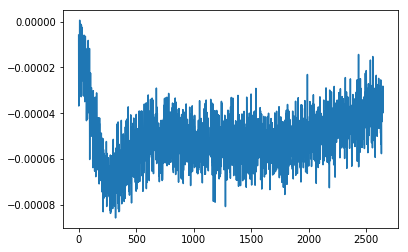

In [53]:
plt.plot(aligner.scores[1:])

# Visualize

In [34]:
def get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.
    v3 supports multiple levels.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict or dict of list): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(lambda: defaultdict(dict))

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        else:
            level_this_structure = level

        if isinstance(level_this_structure, float):
            level_this_structure = [level_this_structure]
                        
        for one_level in level_this_structure:

            contour_2d_wrt_structureVolume_sectionPositions_volResol = \
            find_contour_points_3d(structure_volume_volResol >= one_level,
                                    along_direction='sagittal',
                                    sample_every=sample_every,
                                    positions=positions_of_all_sections_wrt_structureVolume)

            for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():

                contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])

    #             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
    #                 p=contour_3d_wrt_structureVolume_volResol,
    #                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
    #                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

                contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                    p=contour_3d_wrt_structureVolume_volResol,
                    in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                    out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')

                assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
                sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])

                if use_unsided_name_as_key:
                    name = convert_to_unsided_label(name_s)
                else:
                    name = name_s

                structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name][one_level] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]
        
    return structure_contours_wrt_alignedBrainstemCrop_rawResol

In [35]:
# detector_id = 799
detector_id = 19

In [39]:
# for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
for stack in ['MD589']:

    section_margin_um = 500.
    section_margin = int(section_margin_um / SECTION_THICKNESS)

    valid_secmin = np.min(metadata_cache['valid_sections'][stack])
    valid_secmax = np.max(metadata_cache['valid_sections'][stack])

    auto_contours_all_sec_all_structures_all_levels = defaultdict(lambda: defaultdict(dict))
    
    #######################
    
#     chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
#                                                    suffix='structuresHanddrawn', 
#                                                    timestamp='latest')

#     chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

#     chat_structures, chat_structure_resolution = \
#     convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
#                                                           out_resolution='10.0um', stack=stack)

    ########################
    
#     for structure_m in ['Amb_L', 'Amb_R','3N_L','3N_R','4N_L','4N_R',  '6N_L', '6N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
#     for structure_m in ['Amb_L', 'Amb_R']:
    for structure_m in ['SC']:
    
        ####################################################
    
        stack_m_spec = dict(name='atlasV6',
                           vol_type='score',
                           structure=structure_m,
                            resolution='10.0um'
                           )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=detector_id,
                           structure=convert_to_original_name(structure_m),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=warp_setting)

        vo = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, return_origin_instead_of_bbox=True)

        registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
        load_json('/home/yuncong/' + stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json')

        (_, _, secmin), (_, _, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure_m]

        atlas_structures_wrt_wholebrainWithMargin_sections = \
        range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax))

        levels = [0.1, 0.25, 0.5, 0.75, 0.99]

        contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

        ####################################################
        
        simpleGlobal_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=0)

        simpleGlobal_vo = DataManager.load_transformed_volume_v2(alignment_spec=simpleGlobal_alignment_spec, return_origin_instead_of_bbox=True)

        simpleGlobal_contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: simpleGlobal_vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

        ####################################

#         chat_vo = chat_structures[structure_m]

#         chat_contours_all_sections_all_structures_all_levels = \
#         get_structure_contours_from_structure_volumes_v3(volumes={structure_m: chat_vo}, stack=stack, 
#                                                          sections=atlas_structures_wrt_wholebrainWithMargin_sections,
#                                                         resolution='10.0um', level=[.5], sample_every=1)

        ####################################

        # prep2 because at end of get_structure_contours_from_structure_volumes_v2 we used wholebrainXYcropped

        for sec, contours_all_structures_all_levels in sorted(contours_all_sections_all_structures_all_levels.items()):

            if is_invalid(sec=sec, stack=stack):
                continue

            for name_s, cnt_all_levels in contours_all_structures_all_levels.iteritems():
                for level, cnt in cnt_all_levels.iteritems():
                    auto_contours_all_sec_all_structures_all_levels[sec][name_s][level] = cnt.astype(np.int)

    #######################################

    for sec, contours_all_structures_all_levels in sorted(auto_contours_all_sec_all_structures_all_levels.items()):

        if is_invalid(sec=sec, stack=stack):
            continue
            
        for version in ['grayJpeg']:
#         for version in ['NtbNormalizedAdaptiveInvertedGammaJpeg', 'CHATJpeg']:

            img = DataManager.load_image_v2(stack=stack, prep_id=2, resol='raw', version=version, section=sec)
            viz = gray2rgb(img)

            for name_s, cnt_all_levels in contours_all_structures_all_levels.iteritems():

                for level, cnt in cnt_all_levels.iteritems():
                    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, 
                                  color=LEVEL_TO_COLOR_LINE[level], thickness=10)
                    
            for name_s, cnt_all_levels in simpleGlobal_contours_all_sections_all_structures_all_levels[sec].iteritems():

                for level, cnt in cnt_all_levels.iteritems():
                    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, 
                                  color=(255,255,255), 
                                  thickness=10)

# #             # Add CHAT contour
#             if sec in chat_contours_all_sections_all_structures_all_levels:
#                 chat_cnt = chat_contours_all_sections_all_structures_all_levels[sec][name_s][.5]
#                 cv2.polylines(viz, [chat_cnt.astype(np.int)], isClosed=True, color=(255,255,255), thickness=20)
                    
#             fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
#             print fp
#             create_parent_dir_if_not_exists(fp)
#             imsave(fp, viz)

            fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_down16_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
            print fp
            create_parent_dir_if_not_exists(fp)
            imsave(fp, viz[::16, ::16])

2 contours of reconstructed volume is found at position 20 ([51, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 22 ([49, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 374 ([45, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 26 ([41, 4, 2, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 32 ([26, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 34 ([40, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 364 ([7, 5]). Use the longest one.
4 contours of reconstructed volume is found at position 40 ([27, 5, 3, 3]). Use the longest one.
5 contours of reconstructed volume is found at position 60 ([21, 10, 3, 3, 3]). Use the longest one.
Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC22-2015.07.30-22.44.25_MD589_1_0064_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_125.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N22-2015.07.30-17.27.26_MD589_2_0065_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_126.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC22-2015.07.30-22.44.25_MD589_2_0065_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_127.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N22-2015.07.30-17.27.26_MD589_3_0066_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_128.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC22-2015.07.30-22.44.25_MD589_3_0066_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_129.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N23-2015.07.30-17.31.29_MD589_1_0067_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_130.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC23-2015.07.30-22.48.41_MD589_1_0067_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_131.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N23-2015.07.30-17.31.29_MD589_2_0068_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_132.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC23-2015.07.30-22.48.41_MD589_2_0068_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_133.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N23-2015.07.30-17.31.29_MD589_3_0069_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_134.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC23-2015.07.30-22.48.41_MD589_3_0069_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_135.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N24-2015.07.30-17.35.51_MD589_1_0070_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_136.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC24-2015.07.30-22.52.55_MD589_1_0070_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_137.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N24-2015.07.30-17.35.51_MD589_2_0071_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_138.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC24-2015.07.30-22.52.55_MD589_2_0071_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_139.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N24-2015.07.30-17.35.51_MD589_3_0072_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_140.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC24-2015.07.30-22.52.55_MD589_3_0072_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_141.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N25-2015.07.30-17.40.16_MD589_1_0073_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_142.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC25-2015.07.30-22.57.23_MD589_1_0073_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_143.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N25-2015.07.30-17.40.16_MD589_2_0074_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_144.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC25-2015.07.30-22.57.23_MD589_2_0074_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_145.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N25-2015.07.30-17.40.16_MD589_3_0075_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_146.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC25-2015.07.30-22.57.23_MD589_3_0075_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_147.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N26-2015.07.30-17.44.37_MD589_1_0076_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_148.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC26-2015.07.30-23.01.56_MD589_1_0076_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_149.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N26-2015.07.30-17.44.37_MD589_2_0077_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_150.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC26-2015.07.30-23.01.56_MD589_2_0077_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_151.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_152.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_153.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_154.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_155.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_156.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_157.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_158.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_159.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_160.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_161.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_162.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC28-2015.07.30-23.11.15_MD589_2_0083_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_163.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N28-2015.07.30-17.53.43_MD589_3_0084_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_164.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC28-2015.07.30-23.11.15_MD589_3_0084_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_165.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N29-2015.07.30-17.58.29_MD589_1_0085_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_166.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC29-2015.07.30-23.16.01_MD589_1_0085_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_167.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N29-2015.07.30-17.58.29_MD589_2_0086_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_168.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC29-2015.07.30-23.16.01_MD589_2_0086_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_169.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N29-2015.07.30-17.58.29_MD589_3_0087_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_170.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC29-2015.07.30-23.16.01_MD589_3_0087_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_171.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N30-2015.07.30-18.03.11_MD589_1_0088_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_172.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_1_0088_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_173.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N30-2015.07.30-18.03.11_MD589_2_0089_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_174.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_2_0089_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_175.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N30-2015.07.30-18.03.11_MD589_3_0090_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_176.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_3_0090_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_177.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N31-2015.07.30-18.08.35_MD589_1_0091_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_178.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_179.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N31-2015.07.30-18.08.35_MD589_2_0092_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_180.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC31-2015.07.30-23.26.22_MD589_2_0092_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_181.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N32-2015.07.30-18.12.36_MD589_1_0094_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_182.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC32-2015.07.30-23.30.34_MD589_1_0094_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_183.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N32-2015.07.30-18.12.36_MD589_2_0095_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_184.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC32-2015.07.30-23.30.34_MD589_2_0095_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_185.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N33-2015.07.30-18.16.40_MD589_1_0097_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_186.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC33-2015.07.30-23.34.35_MD589_1_0097_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_187.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N33-2015.07.30-18.16.40_MD589_2_0098_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_188.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC33-2015.07.30-23.34.35_MD589_2_0098_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_189.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N34-2015.07.30-18.20.43_MD589_1_0100_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_190.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC34-2015.07.30-23.38.35_MD589_1_0100_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_191.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N34-2015.07.30-18.20.43_MD589_2_0101_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_192.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC34-2015.07.30-23.38.35_MD589_2_0101_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_193.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N35-2015.07.30-18.24.53_MD589_1_0103_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_194.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC35-2015.07.30-23.42.32_MD589_1_0103_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_195.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N35-2015.07.30-18.24.53_MD589_2_0104_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_196.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC35-2015.07.30-23.42.32_MD589_2_0104_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_197.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N36-2015.07.30-18.28.52_MD589_1_0106_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_198.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC36-2015.07.30-23.46.36_MD589_1_0106_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_199.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N36-2015.07.30-18.28.52_MD589_2_0107_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_200.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC36-2015.07.30-23.46.36_MD589_2_0107_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_201.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N37-2015.07.30-18.32.51_MD589_1_0109_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_202.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC37-2015.07.30-23.50.39_MD589_1_0109_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_203.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N37-2015.07.30-18.32.51_MD589_2_0110_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_204.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC37-2015.07.30-23.50.39_MD589_2_0110_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_205.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N38-2015.07.30-18.36.50_MD589_1_0112_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_206.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC38-2015.07.30-23.54.24_MD589_1_0112_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_207.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N38-2015.07.30-18.36.50_MD589_2_0113_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_208.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC38-2015.07.30-23.54.24_MD589_2_0113_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_209.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N39-2015.07.30-18.40.43_MD589_1_0115_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_210.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC39-2015.07.30-23.58.27_MD589_1_0115_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_211.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N39-2015.07.30-18.40.43_MD589_2_0116_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_212.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC39-2015.07.30-23.58.27_MD589_2_0116_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_213.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N40-2015.07.30-18.44.48_MD589_1_0118_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_214.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC40-2015.07.31-00.02.21_MD589_1_0118_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_215.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N40-2015.07.30-18.44.48_MD589_2_0119_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_216.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC40-2015.07.31-00.02.21_MD589_2_0119_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_217.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N41-2015.07.30-18.48.44_MD589_1_0121_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_218.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC41-2015.07.31-00.06.24_MD589_1_0121_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_219.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N41-2015.07.30-18.48.44_MD589_2_0122_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_220.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N42-2015.07.30-18.52.37_MD589_1_0124_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_222.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC42-2015.07.31-00.10.45_MD589_1_0124_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_223.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N42-2015.07.30-18.52.37_MD589_2_0125_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_224.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC42-2015.07.31-00.10.45_MD589_2_0125_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_225.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N43-2015.07.30-18.56.33_MD589_1_0127_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_226.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC43-2015.07.31-00.14.56_MD589_1_0127_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_227.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N43-2015.07.30-18.56.33_MD589_2_0128_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_228.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC43-2015.07.31-00.14.56_MD589_2_0128_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_229.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N44-2015.07.30-19.00.35_MD589_1_0130_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_230.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC44-2015.07.31-00.18.50_MD589_1_0130_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_231.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N44-2015.07.30-19.00.35_MD589_2_0131_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_232.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC44-2015.07.31-00.18.50_MD589_2_0131_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_233.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N45-2015.07.30-19.04.31_MD589_1_0133_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_234.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC45-2015.07.31-00.23.02_MD589_1_0133_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_235.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N45-2015.07.30-19.04.31_MD589_2_0134_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_236.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC45-2015.07.31-00.23.02_MD589_2_0134_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_237.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N46-2015.07.30-19.08.29_MD589_1_0136_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_238.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC46-2015.07.31-00.27.07_MD589_1_0136_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_239.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N46-2015.07.30-19.08.29_MD589_2_0137_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_240.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC46-2015.07.31-00.27.07_MD589_2_0137_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_241.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N47-2015.07.30-19.12.19_MD589_1_0139_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_242.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC47-2015.07.31-00.31.08_MD589_1_0139_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_243.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N47-2015.07.30-19.12.19_MD589_2_0140_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_244.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC47-2015.07.31-00.31.08_MD589_2_0140_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_245.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N48-2015.07.30-19.16.21_MD589_1_0142_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_246.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC48-2015.07.31-00.35.14_MD589_1_0142_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_247.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N48-2015.07.30-19.16.21_MD589_2_0143_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_248.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC48-2015.07.31-00.35.14_MD589_2_0143_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_249.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N49-2015.07.30-19.20.15_MD589_1_0145_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_250.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC49-2015.07.31-00.39.15_MD589_1_0145_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_251.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N49-2015.07.30-19.20.15_MD589_2_0146_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_252.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC49-2015.07.31-00.39.15_MD589_2_0146_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_253.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N50-2015.07.30-19.24.13_MD589_1_0148_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_254.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC50-2015.07.31-00.43.12_MD589_1_0148_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_255.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N50-2015.07.30-19.24.13_MD589_2_0149_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_256.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC50-2015.07.31-00.43.12_MD589_2_0149_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_257.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N51-2015.07.30-19.28.17_MD589_1_0151_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_258.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC51-2015.07.31-00.47.11_MD589_1_0151_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_259.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N51-2015.07.30-19.28.17_MD589_2_0152_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_260.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC51-2015.07.31-00.47.11_MD589_2_0152_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_261.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N51-2015.07.30-19.28.17_MD589_3_0153_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_262.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC51-2015.07.31-00.47.11_MD589_3_0153_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_263.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N52-2015.07.30-19.33.44_MD589_1_0154_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_264.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC52-2015.07.31-00.52.41_MD589_1_0154_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_265.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N52-2015.07.30-19.33.44_MD589_2_0155_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_266.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC52-2015.07.31-00.52.41_MD589_2_0155_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_267.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N52-2015.07.30-19.33.44_MD589_3_0156_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_268.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC52-2015.07.31-00.52.41_MD589_3_0156_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_269.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N53-2015.07.30-19.39.11_MD589_1_0157_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_270.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC53-2015.07.31-00.58.06_MD589_1_0157_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_271.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N53-2015.07.30-19.39.11_MD589_2_0158_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_272.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC53-2015.07.31-00.58.06_MD589_2_0158_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_273.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N53-2015.07.30-19.39.11_MD589_3_0159_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_274.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC53-2015.07.31-00.58.06_MD589_3_0159_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_275.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N54-2015.07.30-19.44.32_MD589_1_0160_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_276.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC54-2015.07.31-01.03.25_MD589_1_0160_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_277.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N54-2015.07.30-19.44.32_MD589_2_0161_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_278.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC54-2015.07.31-01.03.25_MD589_2_0161_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_279.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N54-2015.07.30-19.44.32_MD589_3_0162_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_280.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC54-2015.07.31-01.03.25_MD589_3_0162_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_281.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N55-2015.07.30-19.49.42_MD589_1_0163_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_282.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC55-2015.07.31-01.08.44_MD589_1_0163_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_283.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N55-2015.07.30-19.49.42_MD589_2_0164_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_284.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC55-2015.07.31-01.08.44_MD589_2_0164_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_285.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N55-2015.07.30-19.49.42_MD589_3_0165_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_286.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC55-2015.07.31-01.08.44_MD589_3_0165_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_287.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N56-2015.07.30-19.54.42_MD589_1_0166_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_288.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC56-2015.07.31-01.13.31_MD589_1_0166_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_289.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N56-2015.07.30-19.54.42_MD589_2_0167_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_290.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC56-2015.07.31-01.13.31_MD589_2_0167_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_291.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N56-2015.07.30-19.54.42_MD589_3_0168_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_292.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC56-2015.07.31-01.13.31_MD589_3_0168_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_293.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N57-2015.07.30-19.59.14_MD589_1_0169_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_294.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC57-2015.07.31-01.18.16_MD589_1_0169_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_295.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N57-2015.07.30-19.59.14_MD589_2_0170_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_296.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC57-2015.07.31-01.18.16_MD589_2_0170_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_297.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N57-2015.07.30-19.59.14_MD589_3_0171_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_298.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC57-2015.07.31-01.18.16_MD589_3_0171_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_299.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC58-2015.07.31-01.22.39_MD589_1_0172_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_301.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-N58-2015.07.30-20.03.53_MD589_1_0172_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_302.jpg


Not using image_cache.


/data/CSHL_data_processed/MD589/MD589_prep2_raw_grayJpeg/MD589-IHC58-2015.07.31-01.22.39_MD589_2_0173_prep2_raw_grayJpeg.jpg
/home/yuncong/MD589_atlas_aligned_multilevel_down16_all_structures/grayJpeg/MD589_grayJpeg_303.jpg


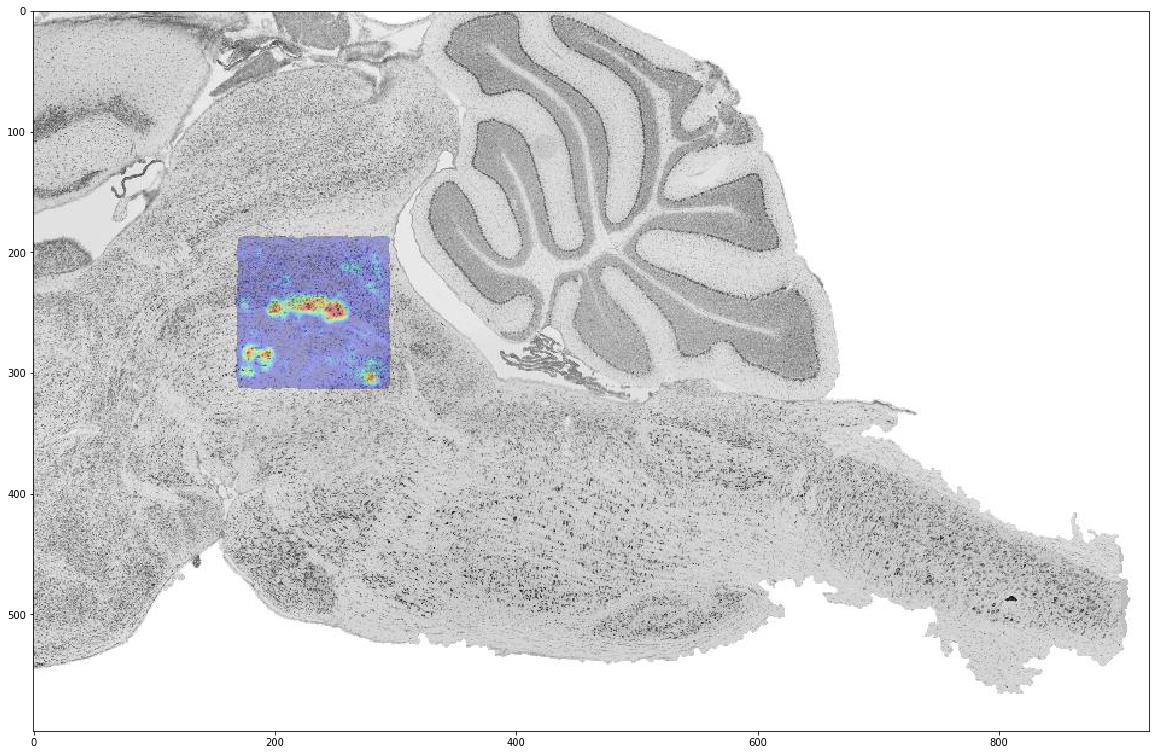

In [28]:
viz = DataManager.load_scoremap_viz_v2(stack='MD593', structure='4N', detector_id=799,  out_resolution='10.0um',
                                     section=191)

plt.figure(figsize=(20,20));
plt.imshow(viz);

# Score history

In [14]:
detector_id = 15

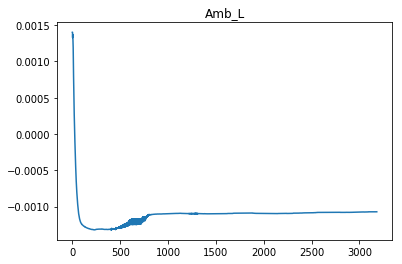

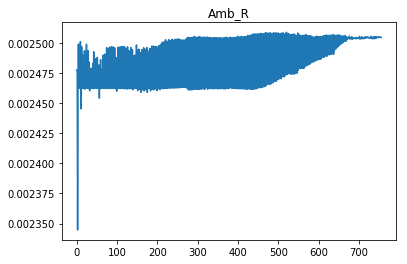

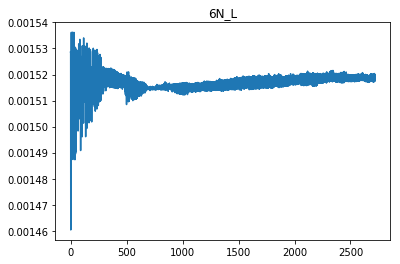

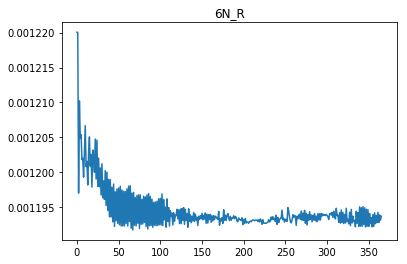

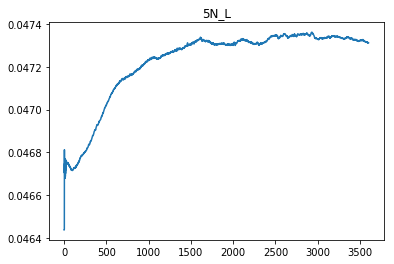

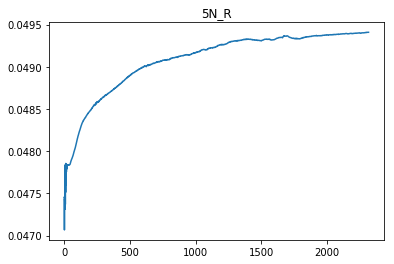

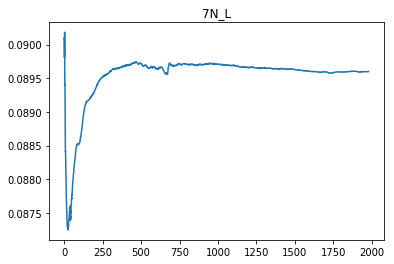

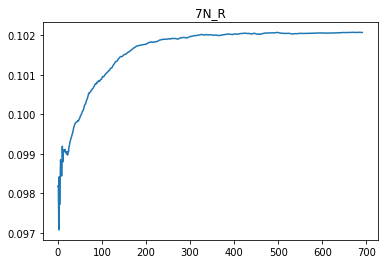

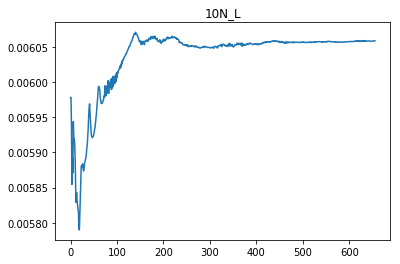

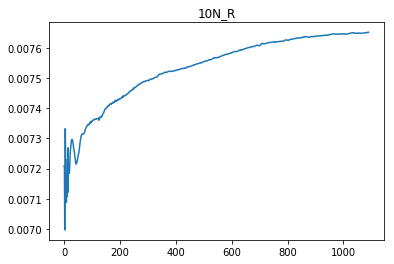

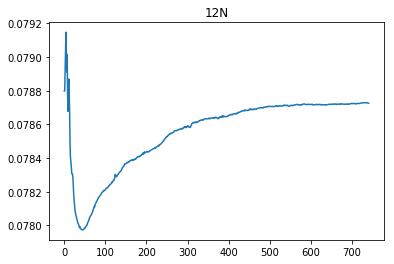

In [15]:
# for structure_m in ['3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
for structure_m in ['Amb_L', 'Amb_R', '6N_L', '6N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:


    stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

    stack_f_spec = dict(name=stack,
                       vol_type='score',
                       detector_id=detector_id,
                       structure=convert_to_original_name(structure_m),
                        resolution='10.0um'
                       )

    local_alignment_spec = dict(stack_m=stack_m_spec, 
                          stack_f=stack_f_spec,
                          warp_setting=27)

    scores = DataManager.load_alignment_results_v3(local_alignment_spec, what='scoreHistory')
    
#     plt.figure(figsize=(20,10));
    plt.figure();
    plt.plot(scores);
    plt.title(structure_m);
    plt.show();

# Compare CHAT structure with automated annotated structures

In [36]:
deviation_from_chat_um_per_structure_all_stacks = {}

for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
    
#     stack = 'CHATM2' # 05092018200440
    # stack = 'CHATM3' # 05092018203614

    chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
                                                   suffix='structuresHanddrawn', 
                                                   timestamp='latest')

    chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

    chat_structures, chat_structure_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
                                                          out_resolution='10.0um', stack=stack)

    deviation_from_chat_um_per_structure = {}

    for name_s, (v_chat, o_chat) in sorted(chat_structures.items()):

        chat_centroid = get_centroid_3d(v_chat) + o_chat
#         chat_centroid = o_chat

        stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=name_s,
                        resolution='10.0um'
                       )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(name_s),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=27)

        v_alg, o_alg = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, 
                                                      return_origin_instead_of_bbox=True)
        alg_centroid = get_centroid_3d(v_alg) + o_alg
#         alg_centroid = o_alg

#         print name_s, chat_centroid, alg_centroid, chat_centroid - alg_centroid, np.linalg.norm(chat_centroid - alg_centroid), 'x 10.0um'

        deviation_from_chat_um_per_structure[name_s] = np.linalg.norm(chat_centroid - alg_centroid) * 10.

    deviation_from_chat_um_per_structure_all_stacks[stack] = deviation_from_chat_um_per_structure

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*structuresHanddrawn*"
0
latest timestamp:  05122018234101
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM3" "/home/yuncong/CSHL_labelings_v3/CHATM3" --exclude "*" --include "*structuresHanddrawn*"
0
latest timestamp:  05102018152000


In [46]:
pd.DataFrame(deviation_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/deviation_from_chat_um_per_structure_all_stacks.csv')

(<matplotlib.figure.Figure at 0x7fd10d3b9310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd10d3b9c10>)

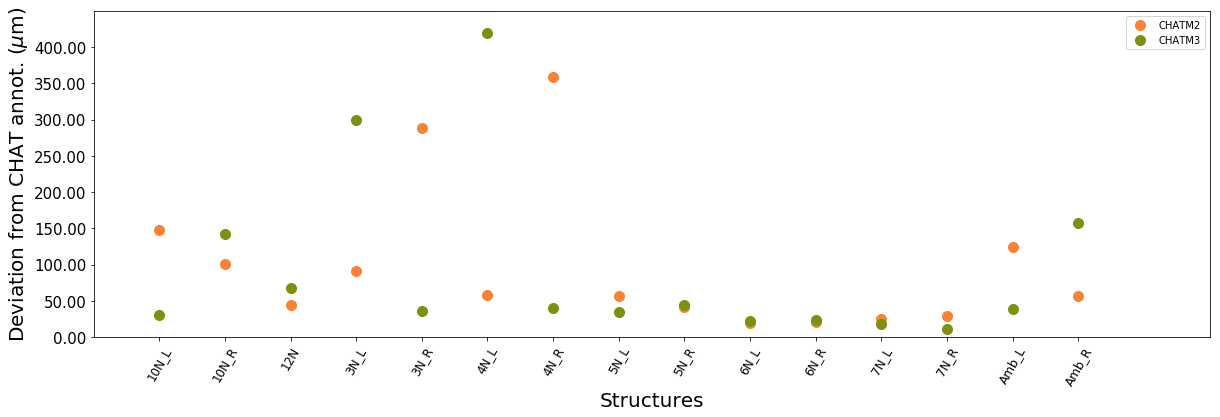

In [37]:
plot_by_stack_by_structure(deviation_from_chat_um_per_structure_all_stacks, 
                           sorted(deviation_from_chat_um_per_structure.keys()), 
                          yticks=np.arange(0, np.max(deviation_from_chat_um_per_structure.values())+10, 50),
                          ylabel='Deviation from CHAT annot. ($\mu$m)')